In [2]:
import numpy as np
import tensorflow as tf
import tensorflow.keras
import cv2
from keras.models import Sequential
from keras.utils import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [7]:
ls

 anaconda3/         Public/
 Desktop/           srcnn.h5
 Documents/         SRCNN-Super_resolution.ipynb
 Downloads/         super_resolution/
 examples.desktop   Templates/
 git_folder/        tensorflow_datasets/
 git_token/        'U-net(Super Resolution).ipynb'
 model.json         Videos/
 Music/             yolov5/
 Pictures/


In [4]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

# defining the size of the image
SIZE = 256
high_img = []
path = './super_resolution/dataset/Raw Data/high_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
path = './super_resolution/dataset/Raw Data/low_res'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '855.jpg':
        break
    else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|████████████████████████████████████████| 855/855 [00:01<00:00, 551.87it/s]


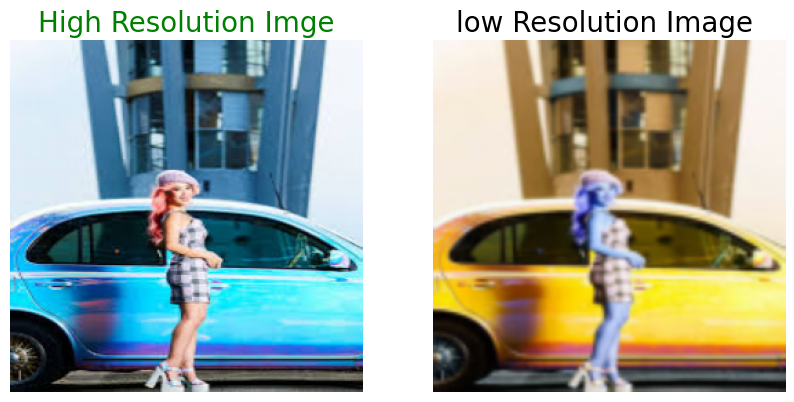

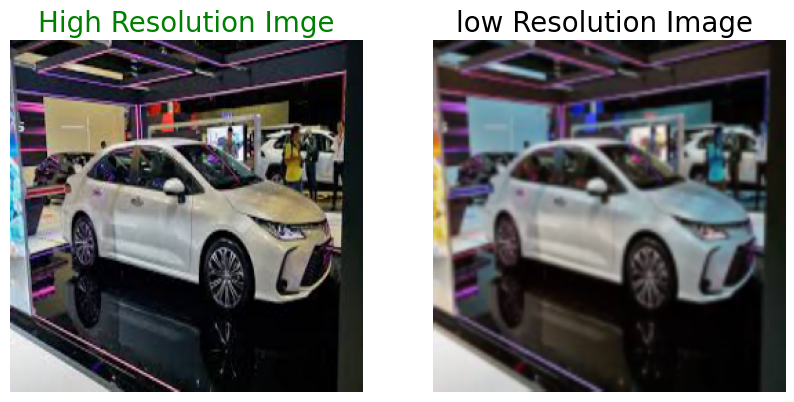

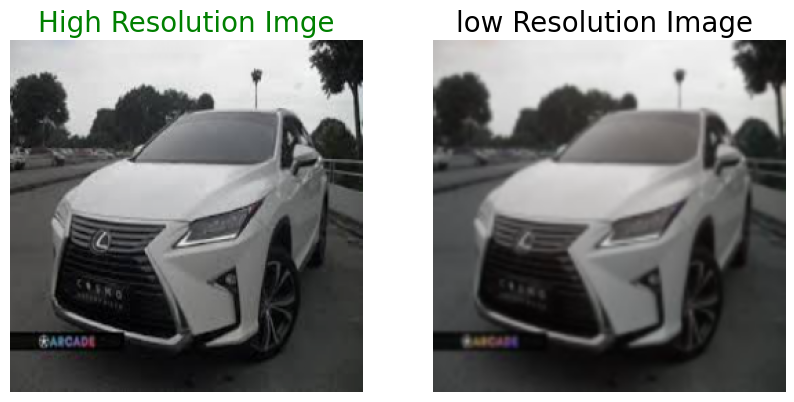

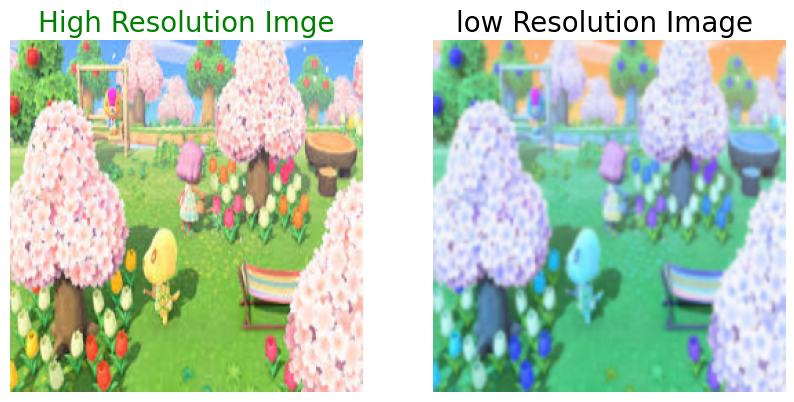

In [5]:
for i in range(4):
    a = np.random.randint(0,855)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'black', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

In [6]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


In [10]:
from tensorflow.keras import layers
from tensorflow import keras
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_3 (Sequential)      (None, 128, 128, 12  3584        ['input_4[0][0]']                
                                8)                                                                
                                                                                                  
 sequential_4 (Sequential)      (None, 64, 64, 128)  147584      ['sequential_3[0][0]']           
                                                                                              

In [11]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

In [12]:
TF_CPP_MIN_LOG_LEVEL=2

In [ ]:
import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [ ]:
model.fit(train_low_image, train_high_image, epochs = 200, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/200
  1/700 [..............................] - ETA: 1:21 - loss: 0.0225 - acc: 0.9116

2022-10-27 17:13:04.038942: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 550502400 exceeds 10% of free system memory.
2022-10-27 17:13:04.181102: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 550502400 exceeds 10% of free system memory.


700/700 [==============================] - 85s 121ms/step - loss: 0.0211 - acc: 0.8229 - val_loss: 0.0211 - val_acc: 0.8289
Epoch 2/200
700/700 [==============================] - 85s 121ms/step - loss: 0.0198 - acc: 0.8238 - val_loss: 0.0201 - val_acc: 0.8864
Epoch 3/200
700/700 [==============================] - 85s 121ms/step - loss: 0.0204 - acc: 0.8229 - val_loss: 0.0235 - val_acc: 0.7930
Epoch 4/200
700/700 [==============================] - 84s 120ms/step - loss: 0.0196 - acc: 0.8312 - val_loss: 0.0181 - val_acc: 0.8765
Epoch 5/200
700/700 [==============================] - 84s 120ms/step - loss: 0.0194 - acc: 0.8309 - val_loss: 0.0176 - val_acc: 0.8531
Epoch 6/200
700/700 [==============================] - 86s 123ms/step - loss: 0.0188 - acc: 0.8413 - val_loss: 0.0190 - val_acc: 0.9055
Epoch 7/200
700/700 [==============================] - 85s 121ms/step - loss: 0.0189 - acc: 0.8354 - val_loss: 0.0214 - val_acc: 0.7679
Epoch 8/200
700/700 [==============================] - 85s 1

1/1 [==============================] - 0s 49ms/step


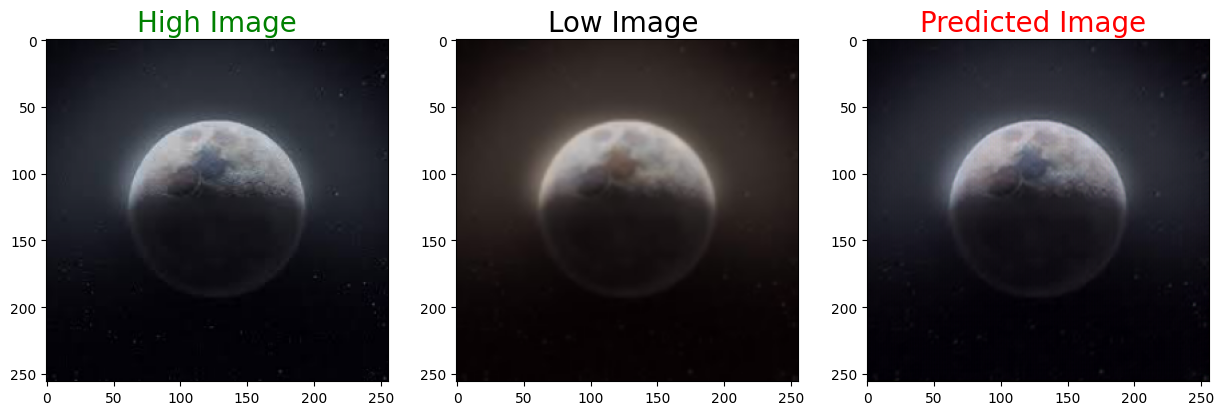

1/1 [==============================] - 0s 46ms/step


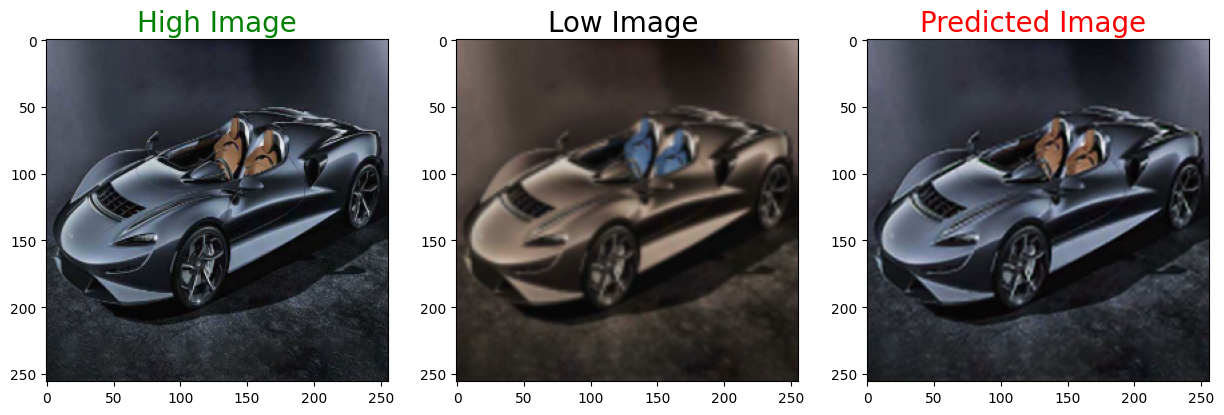

1/1 [==============================] - 0s 52ms/step


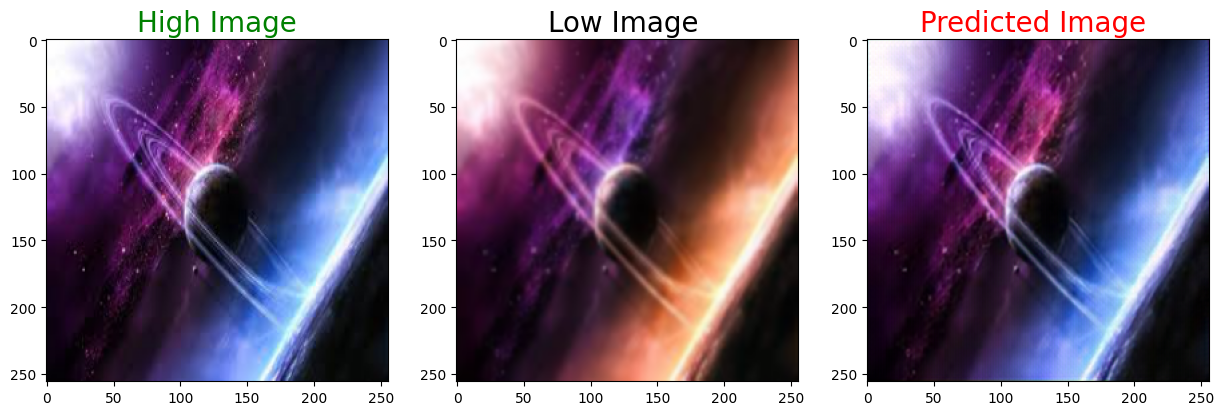

1/1 [==============================] - 0s 49ms/step


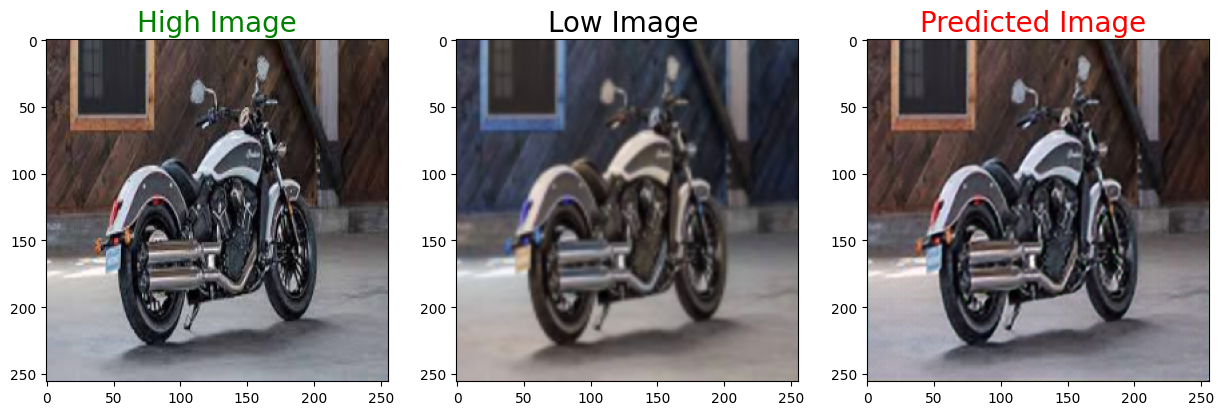

1/1 [==============================] - 0s 48ms/step


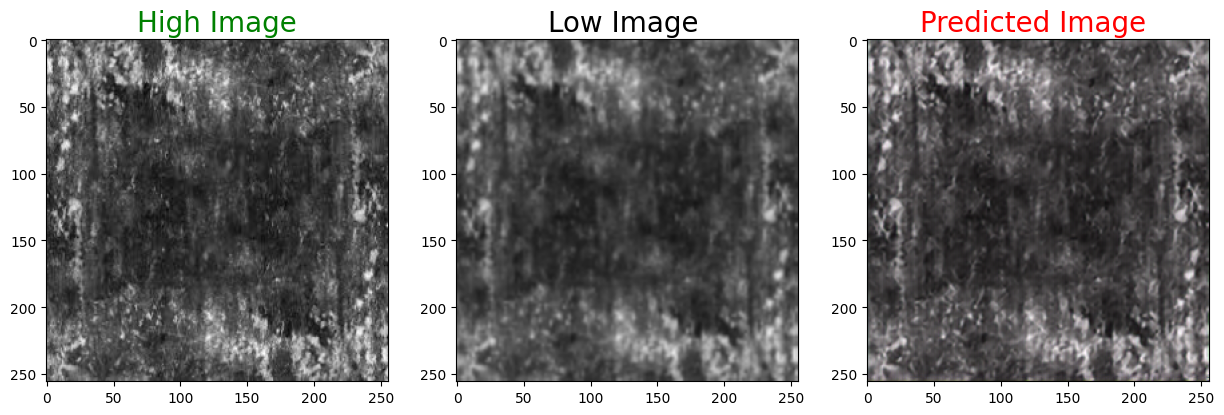

1/1 [==============================] - 0s 50ms/step


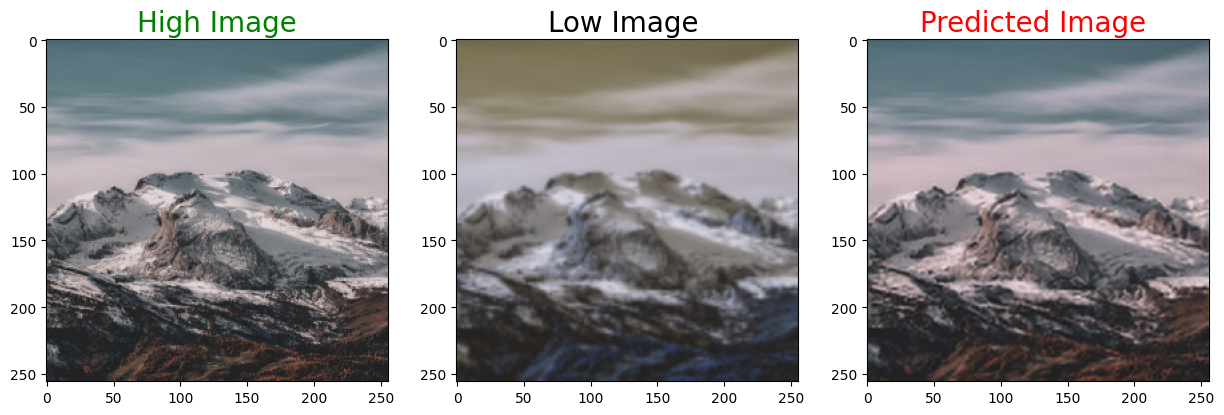

1/1 [==============================] - 0s 49ms/step


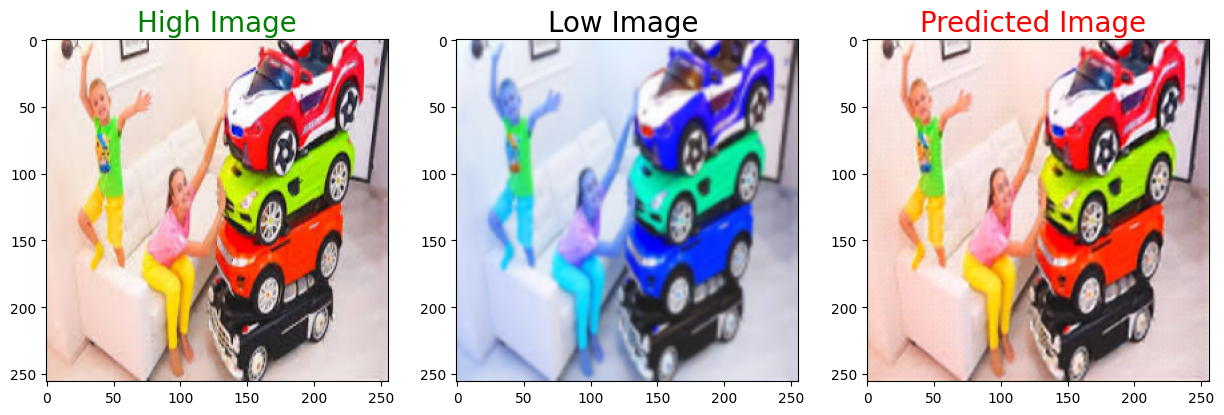

1/1 [==============================] - 0s 53ms/step


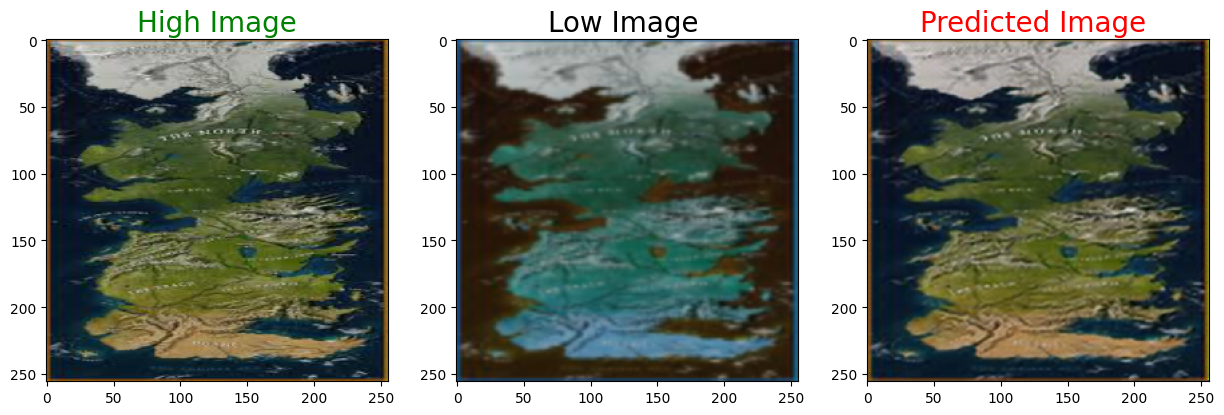

1/1 [==============================] - 0s 47ms/step


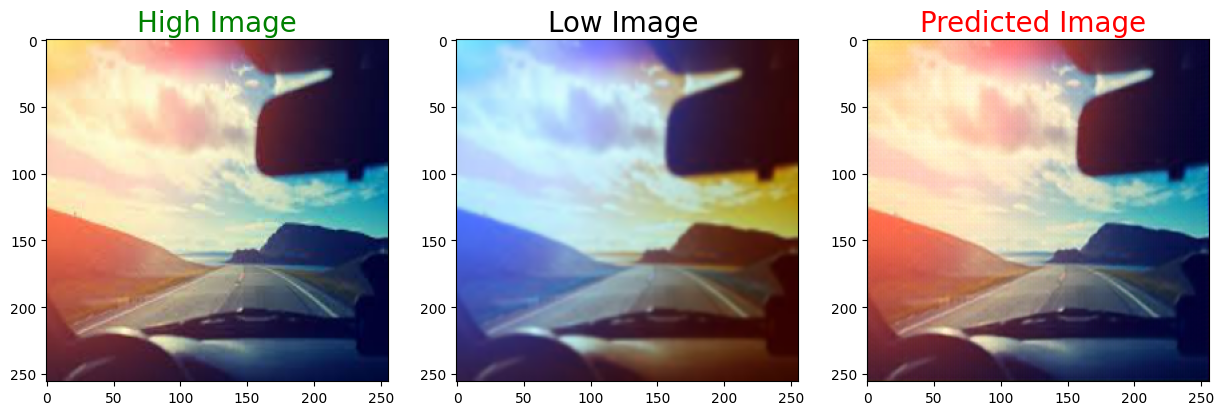

1/1 [==============================] - 0s 47ms/step


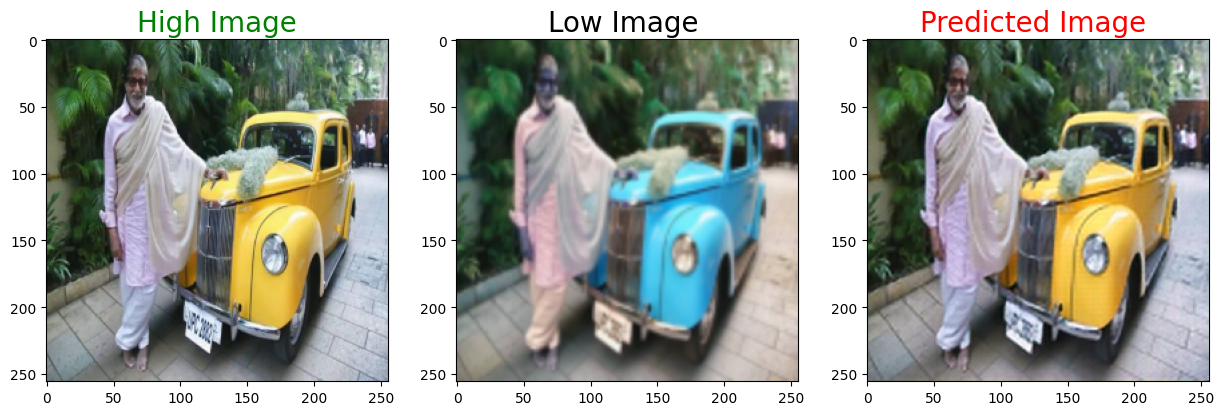

1/1 [==============================] - 0s 48ms/step


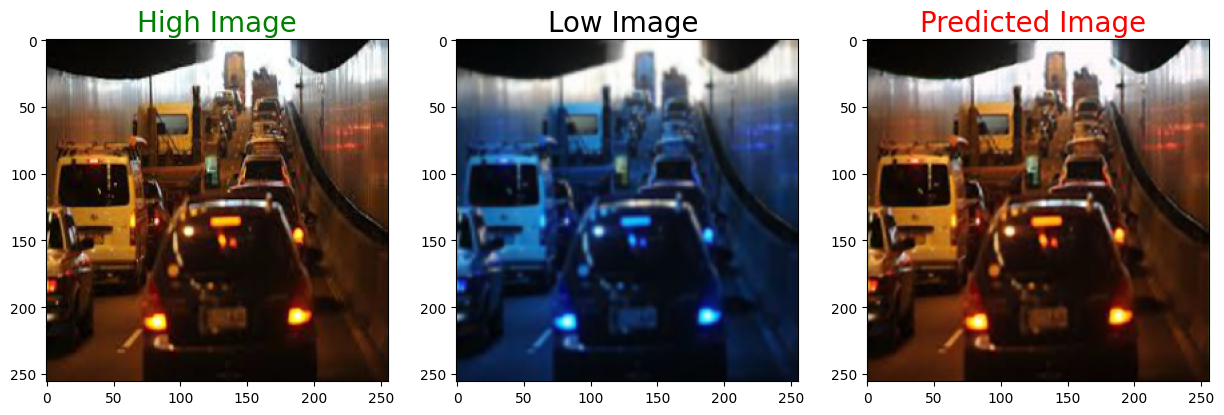

In [16]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High Image', color = 'green', fontsize = 20)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low Image ', color = 'black', fontsize = 20)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ', color = 'Red', fontsize = 20)
    plt.imshow(predicted)
   
    plt.show()

for i in range(10,21):
    
    predicted = np.clip(model.predict(test_low_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[i],test_low_image[i],predicted)

In [15]:
model.save("final_model_2.h5")